<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/Joint_ARMA(1%2C1)_%2B_GARCH(1%2C1)_in_R.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install (if needed) and load required packages
#if (!require("quantmod")) install.packages("quantmod", dependencies=TRUE)
#if (!require("rugarch")) install.packages("rugarch", dependencies=TRUE)
#if (!require("ggplot2")) install.packages("ggplot2", dependencies=TRUE)

In [2]:
library(quantmod)
library(rugarch)
library(ggplot2)

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:stats’:

    sigma




In [3]:
#-----------------------------
# 1. Download stock data from Yahoo Finance
# Here we use Apple Inc. ("AAPL") as an example.
ticker <- "HDFCBANK.NS"
start_date <- "2020-01-01"
end_date   <- "2025-01-01"
getSymbols(ticker, src = "yahoo", from = start_date, to = end_date, auto.assign = TRUE)

[1] "HDFCBANK.NS"

In [4]:
# Use Adjusted Close prices
prices <- Ad(get(ticker))

#-----------------------------
# 2. Compute daily logarithmic returns in percentage
log_returns <- 100 * diff(log(prices))
log_returns <- na.omit(log_returns)

In [5]:
#-----------------------------
# 3. Split data into training and testing sets
n <- length(log_returns)
train_size <- floor(0.8 * n)
train_data <- log_returns[1:train_size]
test_data  <- log_returns[(train_size + 1):n]

In [6]:
# Determine the starting price for forecasting.
# Note: Since returns are computed as diff(log(prices)), the first return corresponds to prices[2].
# The last training return is at position train_size and corresponds to prices[train_size + 1].
last_train_price <- as.numeric(prices[train_size + 1])

In [7]:
#-----------------------------
# 4. Specify and fit ARMA(1,1) + GARCH(1,1) model using rugarch
spec <- ugarchspec(
  variance.model = list(model = "eGARCH", garchOrder = c(1, 1)),
  mean.model     = list(armaOrder = c(1, 1), include.mean = TRUE),
  distribution.model = "std"
)

In [8]:
# Fit the model on the training data
fit <- ugarchfit(spec = spec, data = train_data)

In [9]:
# Fit the model on the training data
fit <- ugarchfit(spec = spec, data = train_data)

In [10]:
#-----------------------------
# 5. Forecast test period using Monte Carlo simulation
# Define forecast horizon as the length of the test data
n_ahead <- length(test_data)
# Run Monte Carlo simulation with 500 simulated paths
sim <- ugarchsim(fit, n.sim = n_ahead, n.start = 0, m.sim = 500)

In [11]:
# Extract simulated series; result is a matrix: rows = forecast steps, columns = simulation paths
sim_matrix <- fitted(sim)

In [12]:
# Convert simulated returns from percentage to log returns (i.e., divide by 100)
sim_log_returns <- sim_matrix / 100

In [13]:
# For each simulation path, compute cumulative log return and convert to price
# Each column is a simulation path; use last_train_price as the starting price.
sim_cum_log_returns <- apply(sim_log_returns, 2, cumsum)
sim_prices <- last_train_price * exp(sim_cum_log_returns)

In [14]:
# For each forecast horizon, compute the mean, 2.5% and 97.5% quantiles (95% CI)
price_forecast_mean  <- apply(sim_prices, 1, mean)
price_forecast_lower <- apply(sim_prices, 1, quantile, probs = 0.025)
price_forecast_upper <- apply(sim_prices, 1, quantile, probs = 0.975)

In [15]:
# Create a time index for the forecast based on the test data dates
forecast_dates <- index(test_data)

In [16]:
#-----------------------------
# 6. Prepare data for plotting
# Create a data frame for the actual historical prices
df_prices <- data.frame(Date = index(prices),
                        Price = as.numeric(prices))

# Create a data frame for the forecasted prices (for test period)
df_forecast <- data.frame(Date = forecast_dates,
                          Forecast = price_forecast_mean,
                          Lower = price_forecast_lower,
                          Upper = price_forecast_upper)

# Create a data frame for actual prices in the test period
# Note: since returns series has one fewer observation than prices, adjust the index:
test_price_dates <- index(prices)[(train_size + 1 + 1):length(prices)]
df_test <- data.frame(Date = test_price_dates,
                      Price = as.numeric(prices[(train_size + 2):length(prices)]))

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


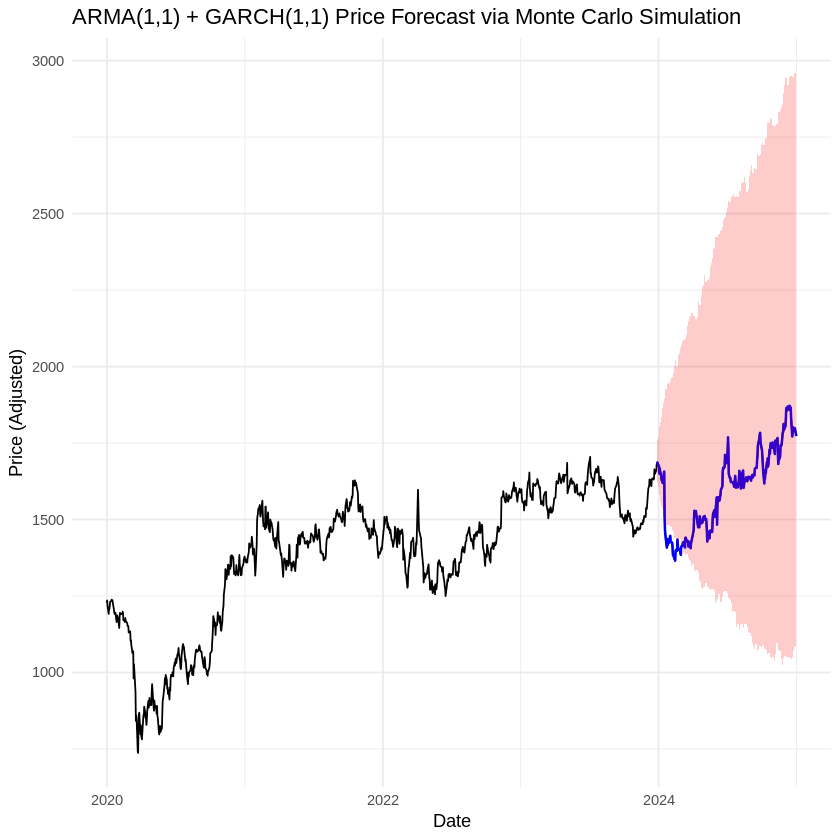

In [17]:
#-----------------------------
# 7. Plot the historical prices and overlay the forecast with a 95% CI for the test period
ggplot() +
  geom_line(data = df_prices, aes(x = Date, y = Price), color = "black", size = 0.5) +
  geom_line(data = df_test, aes(x = Date, y = Price), color = "blue", size = 0.7) +
  geom_ribbon(data = df_forecast, aes(x = Date, ymin = Lower, ymax = Upper),
              fill = "red", alpha = 0.2) +
  labs(title = "ARMA(1,1) + GARCH(1,1) Price Forecast via Monte Carlo Simulation",
       x = "Date", y = "Price (Adjusted)") +
  theme_minimal()